In [120]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import pygad
import itertools
import random
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams["figure.figsize"] = (10, 7)

In [121]:
data = pd.read_excel("sp500_historical_data.xlsx")
data

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol
0,2023-04-03,105.150002,105.839996,104.180000,104.570000,104.570000,4017300,MMM
1,2023-04-04,104.900002,104.900002,102.070000,102.250000,102.250000,3473300,MMM
2,2023-04-05,102.360001,102.769997,101.680000,102.290001,102.290001,2652000,MMM
3,2023-04-06,102.349998,102.800003,101.519997,101.559998,101.559998,2419200,MMM
4,2023-04-10,101.599998,103.129997,101.050003,102.760002,102.760002,2880200,MMM
...,...,...,...,...,...,...,...,...
5005,2023-04-11,171.550003,172.429993,170.830002,171.210007,170.843094,1197900,ZTS
5006,2023-04-12,172.910004,174.789993,171.160004,171.449997,171.082565,1852200,ZTS
5007,2023-04-13,172.500000,174.009995,170.929993,173.539993,173.168076,1324900,ZTS
5008,2023-04-14,172.860001,174.660004,172.610001,174.600006,174.225830,1193700,ZTS


In [122]:
df = data.copy()
start_date = "2023-04-01"
end_date = "2023-04-18"
df = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)]
print(df)
df = df[["Symbol", "Date", "Close"]].rename(columns={"Close": "price"}).reset_index(drop=True)
tickers = df["Symbol"].unique()

tickers_map = {i : j for i,j in zip(tickers, range(len(tickers)))}
tickers_map_reverse = {j : i for i,j in zip(tickers, range(len(tickers)))}

df["ticker_index"]  = df["Symbol"].map(tickers_map)
firsts = (df.groupby('Symbol').transform('first'))
df["adj_price"] = df["price"] / firsts["price"]
df = df[["Symbol", "ticker_index", "Date", "adj_price"]]


           Date        Open        High         Low       Close   Adj Close  \
0    2023-04-03  105.150002  105.839996  104.180000  104.570000  104.570000   
1    2023-04-04  104.900002  104.900002  102.070000  102.250000  102.250000   
2    2023-04-05  102.360001  102.769997  101.680000  102.290001  102.290001   
3    2023-04-06  102.349998  102.800003  101.519997  101.559998  101.559998   
4    2023-04-10  101.599998  103.129997  101.050003  102.760002  102.760002   
...         ...         ...         ...         ...         ...         ...   
5005 2023-04-11  171.550003  172.429993  170.830002  171.210007  170.843094   
5006 2023-04-12  172.910004  174.789993  171.160004  171.449997  171.082565   
5007 2023-04-13  172.500000  174.009995  170.929993  173.539993  173.168076   
5008 2023-04-14  172.860001  174.660004  172.610001  174.600006  174.225830   
5009 2023-04-17  174.009995  174.809998  172.309998  174.619995  174.245773   

       Volume Symbol  
0     4017300    MMM  
1    

In [123]:
df.groupby("Symbol").count().sort_values("Date")

,ticker_index,Date,adj_price
Symbol,,,
A,10,10,10
NWL,10,10,10
NVR,10,10,10
NVDA,10,10,10
NUE,10,10,10
...,...,...,...
EOG,10,10,10
ENPH,10,10,10
EMR,10,10,10


#### Genetic algorithm

Below we try to find the best combination of 10 stocks that give the best return over the defined time period

In [124]:
## Define fitness function and utils

def portfolio_generate(df, tickers):
    portfolio = df[df['ticker_index'].isin(tickers)]
    portfolio = portfolio.groupby("Date", as_index=False).sum()
    portfolio = portfolio.sort_values("Date")
    return portfolio

def portfolio_return(portfolio):
    first_price = portfolio["adj_price"].iloc[0]
    last_price = portfolio["adj_price"].iloc[-1]
    # print(f"last_price / first_price - 1: {last_price / first_price - 1}")
    return last_price / first_price - 1

def portfolio_risk(portfolio):
    portfolio["daily_change"] = portfolio["adj_price"].diff(1)
    portfolio["daily_change"] = portfolio["daily_change"] / portfolio["adj_price"]
    print("\n\ndaily_change: ", portfolio["daily_change"])
    # print("\n\nadj_price: ",portfolio["adj_price"])
    return portfolio["daily_change"].std()

def fitness_func(ga_instance, solution, solution_idx):
    portfolio = portfolio_generate(df, solution)
    ret = portfolio_return(portfolio)
    ris = portfolio_risk(portfolio)
    fitness = ret / ris
    print(f"portfolio: {portfolio}")
    #　print(f"ret: {ret}")
    # print(f"ris: {ris}")
    
    # print(f"fitness: {fitness}")
    return fitness

def visualize(df, solution):
    solution_fitness = fitness_func(None, solution, None)
    portfolio  = portfolio_generate(df, solution)
    portfolio["adj_price"] = (portfolio["adj_price"] / portfolio["adj_price"].iloc[0] ) * 100
    ax = portfolio.plot.line(x="Date", y="adj_price")
    ax.set_ylim(90, 190)
    ret = round(portfolio_return(portfolio) * 100, 1)
    ris = round(portfolio_risk(portfolio) * 100, 1)
    
    print(f"Parameters of the best solution : {[tickers_map_reverse[i] for i in solution]}")
    print(f"Return: {ret}%")
    print(f"Risk: {ris}%")
    print(f"Risk adjusted return = {round(solution_fitness,1)}%")


In [130]:
## Define Genetic Algorithm

fitness_function = fitness_func

num_generations = 30
num_genes = 10

sol_per_pop = 90
num_parents_mating =  50

init_range_low = 0
init_range_high = 501
gene_type = int

parent_selection_type = "sss"
keep_parents = 30

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 30

In [131]:
## Initiate and run genetic algorithm

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_type=gene_type,
                       allow_duplicate_genes=False,
                       random_seed=2)
ga_instance.run()
for i,j in zip (ga_instance.best_solutions, ga_instance.best_solutions_fitness):
  print([(tickers_map_reverse[k],k) for k in sorted(i)],j)



daily_change:  0         NaN
1   -0.004112
2    0.009953
3    0.001356
4   -0.000302
5    0.007468
6   -0.005251
7    0.013231
8   -0.009875
9    0.004848
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03          2073  10.000000           NaN
1 2023-04-04          2073   9.959049     -0.004112
2 2023-04-05          2073  10.059168      0.009953
3 2023-04-06          2073  10.072825      0.001356
4 2023-04-10          2073  10.069786     -0.000302
5 2023-04-11          2073  10.145552      0.007468
6 2023-04-12          2073  10.092556     -0.005251
7 2023-04-13          2073  10.227877      0.013231
8 2023-04-14          2073  10.127861     -0.009875
9 2023-04-17          2073  10.177202      0.004848


daily_change:  0         NaN
1   -0.017692
2   -0.008766
3    0.001451
4    0.008873
5    0.010084
6   -0.004962
7    0.014903
8   -0.002495
9    0.003681
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

c:\Users\Patrick\anaconda3\lib\site-packages\pygad\helper\unique.py:222: UserWarning: You set 'allow_duplicate_genes=False' but there is no enough values to prevent duplicates.
  if not self.suppress_warnings: warnings.warn("You set 'allow_duplicate_genes=False' but there is no enough values to prevent duplicates.")
c:\Users\Patrick\anaconda3\lib\site-packages\pygad\helper\unique.py:92: UserWarning: Failed to find a unique value for gene with index 3 whose value is 169. Consider adding more values in the gene space or use a wider range for initial population or random mutation.
  if not self.suppress_warnings: warnings.warn("Failed to find a unique value for gene with index {gene_idx} whose value is {gene_value}. Consider adding more values in the gene space or use a wider range for initial population or random mutation.".format(gene_idx=duplicate_index, gene_value=solution[duplicate_index]))




daily_change:  0         NaN
1   -0.006762
2   -0.002234
3    0.010859
4    0.002542
5    0.001147
6   -0.008248
7    0.018963
8    0.000328
9    0.006215
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03          2343  10.000000           NaN
1 2023-04-04          2343   9.932838     -0.006762
2 2023-04-05          2343   9.910702     -0.002234
3 2023-04-06          2343  10.019499      0.010859
4 2023-04-10          2343  10.045038      0.002542
5 2023-04-11          2343  10.056570      0.001147
6 2023-04-12          2343   9.974306     -0.008248
7 2023-04-13          2343  10.167106      0.018963
8 2023-04-14          2343  10.170441      0.000328
9 2023-04-17          2343  10.234044      0.006215


daily_change:  0         NaN
1   -0.002801
2   -0.000484
3    0.007768
4    0.001817
5    0.005314
6   -0.002416
7    0.023079
8   -0.005764
9    0.008630
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

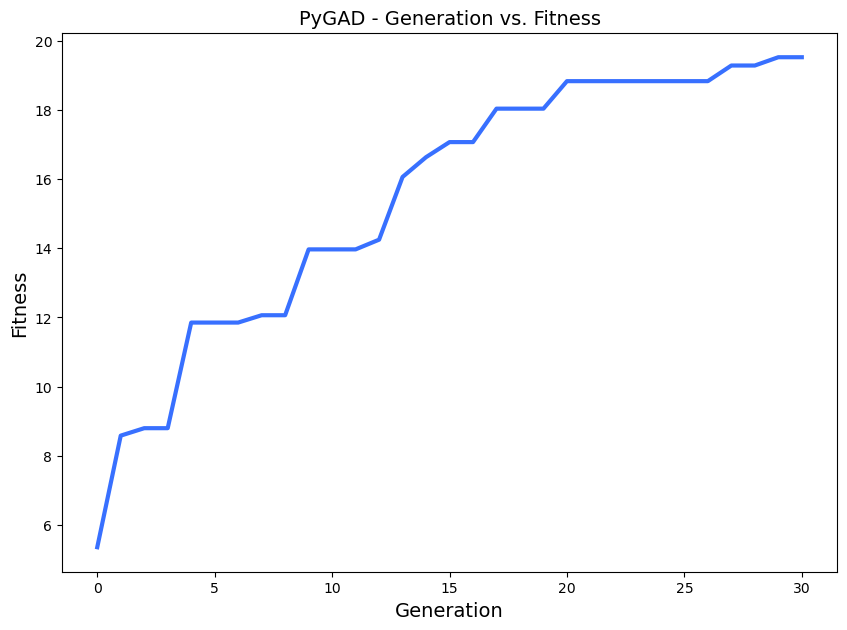



daily_change:  0         NaN
1    0.000914
2    0.002246
3    0.004058
4    0.007382
5    0.010147
6    0.002559
7    0.011794
8    0.004547
9    0.006180
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03          1727  10.000000           NaN
1 2023-04-04          1727  10.009151      0.000914
2 2023-04-05          1727  10.031680      0.002246
3 2023-04-06          1727  10.072553      0.004058
4 2023-04-10          1727  10.147466      0.007382
5 2023-04-11          1727  10.251487      0.010147
6 2023-04-12          1727  10.277791      0.002559
7 2023-04-13          1727  10.400457      0.011794
8 2023-04-14          1727  10.447969      0.004547
9 2023-04-17          1727  10.512942      0.006180


daily_change:  0         NaN
1    0.003523
2    0.002029
3    0.000491
4    0.009679
5    0.004230
6   -0.001612
7    0.013285
8   -0.002078
9    0.007744
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

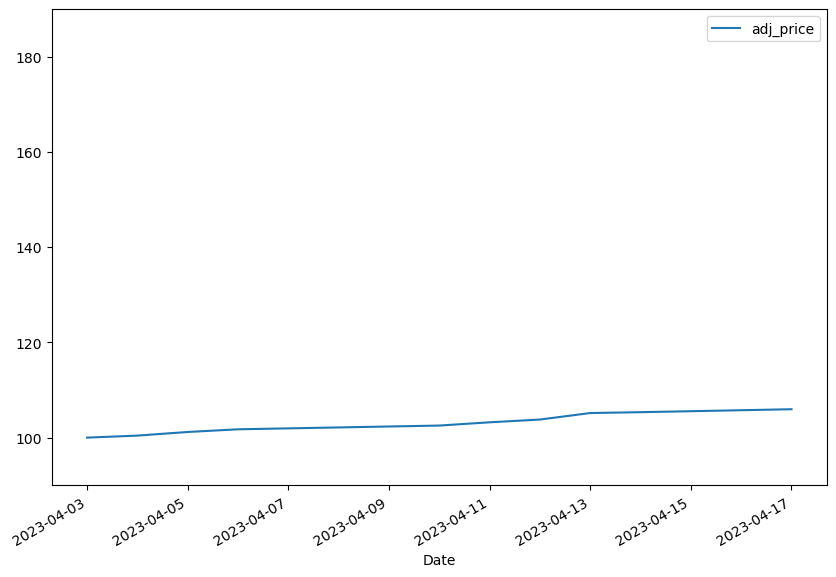

In [132]:
## Plot training, best resuls

ga_instance.plot_fitness(save_dir=None)
[solution, _, __] = ga_instance.best_solution()
visualize(df, solution)



daily_change:  0         NaN
1   -0.007501
2    0.004692
3    0.008463
4    0.013551
5    0.022995
6   -0.000406
7    0.022011
8    0.007851
9    0.014464
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03          2355  10.000000           NaN
1 2023-04-04          2355   9.925546     -0.007501
2 2023-04-05          2355   9.972332      0.004692
3 2023-04-06          2355  10.057452      0.008463
4 2023-04-10          2355  10.195616      0.013551
5 2023-04-11          2355  10.435587      0.022995
6 2023-04-12          2355  10.431350     -0.000406
7 2023-04-13          2355  10.666125      0.022011
8 2023-04-14          2355  10.750526      0.007851
9 2023-04-17          2355  10.908303      0.014464


daily_change:  0         NaN
1   -0.007501
2    0.004692
3    0.008463
4    0.013551
5    0.022995
6   -0.000406
7    0.022011
8    0.007851
9    0.014464
Name: daily_change, dtype: float64
Parameters of the best solution :

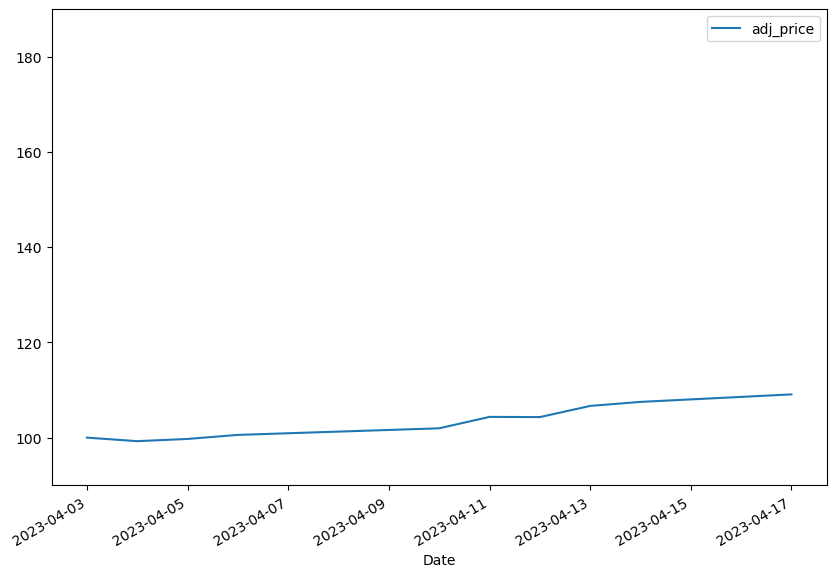

In [128]:
## Top 10 performers benchmark

firsts = df.groupby("ticker_index", as_index=False).first()
firsts = firsts.rename({"adj_price": "first_price"}, axis=1)[["ticker_index", "first_price"]]
lasts = df.groupby("ticker_index", as_index=False).last()
lasts = lasts.rename({"adj_price": "last_price"}, axis=1)[["ticker_index", "last_price"]]

df_ = firsts.merge(lasts, on="ticker_index", how="left")
df_["return"] = df_["last_price"] / df_["first_price"]
df_ = df_.sort_values("return", ascending=False)
best_return = df_.head(10)["ticker_index"].unique()

visualize(df, best_return)



daily_change:  0         NaN
1   -0.010509
2   -0.002403
3    0.000692
4    0.006391
5    0.006369
6   -0.005324
7    0.007888
8   -0.004833
9    0.006827
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index   adj_price  daily_change
0 2023-04-03        125250  501.000000           NaN
1 2023-04-04        125250  495.789721     -0.010509
2 2023-04-05        125250  494.601185     -0.002403
3 2023-04-06        125250  494.943600      0.000692
4 2023-04-10        125250  498.127311      0.006391
5 2023-04-11        125250  501.320114      0.006369
6 2023-04-12        125250  498.665120     -0.005324
7 2023-04-13        125250  502.630001      0.007888
8 2023-04-14        125250  500.212605     -0.004833
9 2023-04-17        125250  503.650781      0.006827


daily_change:  0         NaN
1   -0.010509
2   -0.002403
3    0.000692
4    0.006391
5    0.006369
6   -0.005324
7    0.007888
8   -0.004833
9    0.006827
Name: daily_change, dtype: float64
Parameters of the best

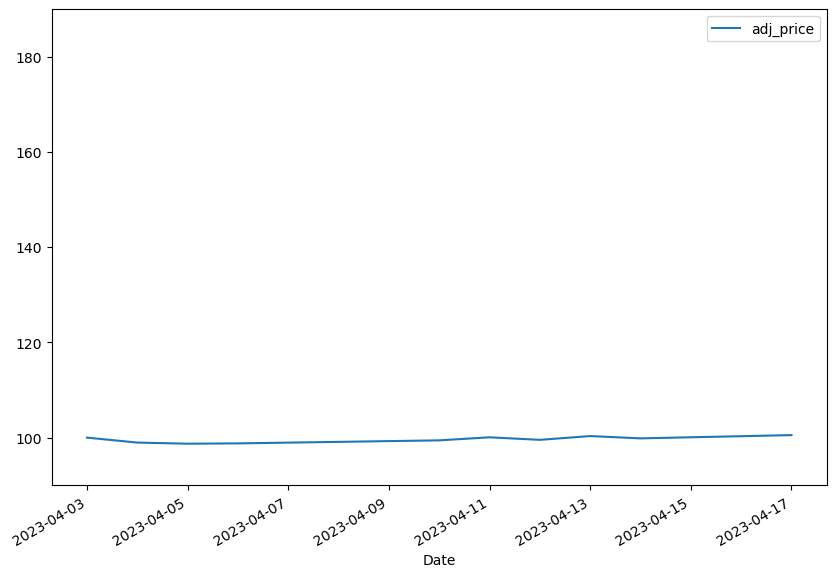

In [129]:
## S&P 500 benchmark

visualize(df, df["ticker_index"].unique())